# Attention Head
* so in transformer we do use multiplicative attention ,there are two type of attention one is additive and other is scale dot attention
* so in research paper  "attention all u need" they hav incorported multiplicative attention
* i assume it just involves addition rather than the multiplication to calculate the score

dimension of data (directly proportional to) variance

hence the scailing down is down by (dimension of model)**(1/2)


In [143]:
import torch
import numpy as np

In [144]:
#utility function look ahead mask
def create_look_ahead_mask(seq_len):
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
    mask = mask.masked_fill(mask == 1, float('-inf'))
    return mask  # shape: (seq_len, seq_len)


In [145]:
#it has been modified to process the 3d data where the data across the z index correspond to each head

def attention_head(queries, keys, values, dropout=None, mask=None):

  # Calculate the attention scores
  # Scores will have shape (batch_size * sequence_length, batch_size * sequence_length)
  d_k = keys.size(-1)
  scores = torch.matmul(queries, keys.transpose(-2, -1))
  scores = scores / d_k**0.5

#now this look ahead mask will be used in the decoder
  if mask is not None:
# mask should be broadcastable to the shape of the scores tensor
# for 3d input, the mask should have shape (num_heads,batch_size * sequence_length, batch_size * sequence_length)
      scores = scores.masked_fill(mask == 0, -1e9)

  # row mean -1 and -2 means col
  scores = scores.softmax(dim=-1) # apply softmax across the row dimension (keys)


  # Apply dropout
  if dropout is not None:
      scores = dropout(scores)

  # Apply scores to values
  weighted_sum = torch.matmul(scores, values)

  return weighted_sum

### we will test our attention head with custom args

In [146]:
import torch

In [147]:
# Define input dimensions
batch_size = 2
sequence_length = 3
embedding_dim = 4
num_heads = 2
head_dim = embedding_dim // num_heads

# Create sample input tensors with compatible shapes
# Embeddings are now 2D: (batch_size * sequence_length, embedding_dim)
sample_embeddings = torch.randn(batch_size * sequence_length, embedding_dim)

# Create dummy linear layers that output the expected shape for attention_head
# The linear layers now expect an input shape of (batch_size * sequence_length, embedding_dim)
# and output a shape of (batch_size * sequence_length, head_dim)
dummy_key_linear = torch.nn.Linear(embedding_dim, head_dim)
dummy_query_linear = torch.nn.Linear(embedding_dim, head_dim)
dummy_value_linear = torch.nn.Linear(embedding_dim, head_dim)

# Create a dummy dropout layer
dummy_dropout = torch.nn.Dropout(0.1)

# Create a dummy mask
# The mask should have shape (batch_size * sequence_length, batch_size * sequence_length) for 2D input
dummy_mask = torch.ones(batch_size * sequence_length, batch_size * sequence_length) # Assuming no masking for simplicity

# Pass the sample_embeddings through the dummy linear layers to get the keys, queries, and values tensors
# These tensors should have shape (batch_size * sequence_length, head_dim)
sample_keys = dummy_key_linear(sample_embeddings)
sample_queries = dummy_query_linear(sample_embeddings)
sample_values = dummy_value_linear(sample_embeddings)

print("Sample Keys Shape:", sample_keys.shape)
print("Sample Queries Shape:", sample_queries.shape)
print("Sample Values Shape:", sample_values.shape)

# Test the attention_head function with the compatible inputs

  # attention_head now expects 2D inputs for keys, queries, and values
attention_output = attention_head(sample_queries, sample_keys, sample_values, dummy_dropout, dummy_mask)
print("Attention head output shape:", attention_output.shape)


Sample Keys Shape: torch.Size([6, 2])
Sample Queries Shape: torch.Size([6, 2])
Sample Values Shape: torch.Size([6, 2])
Attention head output shape: torch.Size([6, 2])


# testing for the 3d inputs

In [148]:
# Define input dimensions
batch_size = 2
sequence_length = 3
embedding_dim = 4
num_heads = 2
head_dim = embedding_dim // num_heads

# Create sample input tensors with compatible shapes
# Embeddings are now 2D: (batch_size * sequence_length, embedding_dim)
sample_embeddings = torch.randn(batch_size * sequence_length, embedding_dim)

# Create dummy linear layers that output the expected shape for attention_head
# The linear layers now expect an input shape of (batch_size * sequence_length, embedding_dim)
# and output a shape of (batch_size * sequence_length, head_dim)
dummy_key_linear = torch.nn.Linear(embedding_dim, head_dim)
dummy_query_linear = torch.nn.Linear(embedding_dim, head_dim)
dummy_value_linear = torch.nn.Linear(embedding_dim, head_dim)

# Create a dummy dropout layer
dummy_dropout = torch.nn.Dropout(0.1)

# Create a dummy mask
# The mask should have shape (batch_size * sequence_length, batch_size * sequence_length) for 2D input
dummy_mask = torch.ones(batch_size * sequence_length, batch_size * sequence_length) # Assuming no masking for simplicity

# Pass the sample_embeddings through the dummy linear layers to get the keys, queries, and values tensors
# These tensors should have shape (batch_size * sequence_length, head_dim)
sample_keys = dummy_key_linear(sample_embeddings)
sample_queries = dummy_query_linear(sample_embeddings)
sample_values = dummy_value_linear(sample_embeddings)

print("Sample Keys Shape:", sample_keys.shape)
print("Sample Queries Shape:", sample_queries.shape)
print("Sample Values Shape:", sample_values.shape)

# Test the attention_head function with the compatible inputs

  # attention_head now expects 2D inputs for keys, queries, and values
attention_output = attention_head(sample_queries, sample_keys, sample_values, dummy_dropout, dummy_mask)
print("Attention head output shape:", attention_output.shape)


Sample Keys Shape: torch.Size([6, 2])
Sample Queries Shape: torch.Size([6, 2])
Sample Values Shape: torch.Size([6, 2])
Attention head output shape: torch.Size([6, 2])


# Multi Head Attention
#### we create tunable parameters for each head one for query ,key and value

In [149]:
import torch.nn as nn


class MultiHeadAttention(nn.Module):
  def __init__(self,heads,d_model,dropout=0.01,mask=None):
     super(MultiHeadAttention,self).__init__();
     self.heads=heads;
     self.d_model=d_model;
     self.d_key=d_model//heads;
     # Linear layers for query, key, value, and projection
     self.query_linears = nn.Linear(d_model, d_model)
     self.key_linears   = nn.Linear(d_model, d_model)
     self.value_linears = nn.Linear(d_model, d_model)
     self.mask=mask
     #prjection layer will be used to project the concatenated output of all heads to the end of attention in the multihead attention
     self.projection_layer=nn.Linear(d_model,self.d_model)
     #this field is for debugging purposes
     self.attn=None
     self.dropout=nn.Dropout(dropout);

  def forward(self,input_embedding,encoder_output_embedding=None):
    head_dim=self.d_model//self.heads;
    queries=self.query_linears(input_embedding).view(self.heads,-1,head_dim);
    keys=self.key_linears(input_embedding).view(self.heads,-1,head_dim) if(encoder_output_embedding==None) else self.key_linears(encoder_output_embedding).view(self.heads,-1,head_dim);
    values=self.value_linears(input_embedding).view(self.heads,-1,head_dim) if(encoder_output_embedding==None) else self.value_linears(encoder_output_embedding).view(self.heads,-1,head_dim);
    dropout = torch.nn.Dropout(0.1)
    result=attention_head(queries,keys,values,dropout=dropout,).view(-1,self.d_model)
    return self.projection_layer(result)


In [150]:
import torch.nn as nn


class MultiHeadAttention(nn.Module):
  def __init__(self,heads,d_model,dropout=0.01,mask=None):
     super(MultiHeadAttention,self).__init__();
     self.heads=heads;
     self.d_model=d_model;
     self.d_key=d_model//heads;
     # Linear layers for query, key, value, and projection
     self.query_linears = nn.Linear(d_model, d_model)
     self.key_linears   = nn.Linear(d_model, d_model)
     self.value_linears = nn.Linear(d_model, d_model)
     self.mask=mask
     #prjection layer will be used to project the concatenated output of all heads to the end of attention in the multihead attention
     self.projection_layer=nn.Linear(d_model,self.d_model)
     #this field is for debugging purposes
     self.attn=None
     self.dropout=nn.Dropout(dropout);

  def forward(self,input_embedding,encoder_output_embedding=None):
    head_dim=self.d_model//self.heads;
    queries=self.query_linears(input_embedding).view(self.heads,-1,head_dim);
    keys=self.key_linears(input_embedding).view(self.heads,-1,head_dim) if(encoder_output_embedding==None) else self.key_linears(encoder_output_embedding).view(self.heads,-1,head_dim);
    values=self.value_linears(input_embedding).view(self.heads,-1,head_dim) if(encoder_output_embedding==None) else self.value_linears(encoder_output_embedding).view(self.heads,-1,head_dim);
    dropout = torch.nn.Dropout(0.1)
    result=attention_head(queries,keys,values,dropout=dropout,mask=self.mask).view(-1,self.d_model)
    return self.projection_layer(result)


In [151]:
import torch

# Define parameters for MultiHeadAttention
heads = 4
d_model = 128 # Make sure d_model is divisible by heads
dropout_prob = 0.1

# Create a dummy input embedding
batch_size = 2
sequence_length = 10
input_embedding = torch.randn(batch_size, sequence_length, d_model)

# Create an instance of MultiHeadAttention
multi_head_attention = MultiHeadAttention(heads, d_model, dropout=dropout_prob)

# Test the forward method
output = multi_head_attention(input_embedding)

print("Input embedding shape:", input_embedding.shape)
print("Output shape:", output.shape)

Input embedding shape: torch.Size([2, 10, 128])
Output shape: torch.Size([20, 128])


# Adding the add and normalize layer

In [152]:
# this add and normalize layer will be used in the subsidual linkage
# this subisidual is used to acoid the diminishing effect or influence of the original input
def add_norm(prev,input):
  result=prev+input;
  return torch.nn.functional.normalize(result);

# Adding the position wise feed forward

In [153]:
class PositionWiseFFN(nn.Module):
  def __init__(self,d_model,d_ff,dropout=0.1):
    super(PositionWiseFFN,self).__init__();
    self.linear1=nn.Linear(d_model,d_ff);
    self.linear2=nn.Linear(d_ff,d_model);
    self.dropout=nn.Dropout(dropout);

  def forward(self,x):
    x=self.linear1(x);
    x=torch.relu(x);
    x=self.dropout(x);
    x=self.linear2(x);
    return x;


# test case for the position wise feed forward network

In [154]:
# Test case for PositionWiseFFN

# Define input dimensions
batch_size = 2
sequence_length = 3
embedding_dim = 4
d_ff = 8 # Dimension of the feed-forward hidden layer

# Create sample input tensor with shape (batch_size * sequence_length, embedding_dim)
sample_input = torch.randn(batch_size * sequence_length, embedding_dim)

print("Sample Input Shape for PositionWiseFFN:", sample_input.shape)

# Instantiate the PositionWiseFFN module
position_wise_ffn = PositionWiseFFN(d_model=embedding_dim, d_ff=d_ff)

# Pass the sample input through the PositionWiseFFN module
try:
  print(sample_input)
  output_ffn = position_wise_ffn(sample_input)
  print("PositionWiseFFN Output Shape:", output_ffn)
except Exception as e:
  print(f"An error occurred during the PositionWiseFFN test: {e}")

Sample Input Shape for PositionWiseFFN: torch.Size([6, 4])
tensor([[ 1.5502, -0.1603,  1.2397,  0.7833],
        [ 0.6445,  0.8216, -1.5646, -0.7228],
        [-1.6822,  2.7481,  1.0679, -1.5520],
        [ 0.2382,  0.5249,  0.4163,  0.0434],
        [ 0.7894,  0.6238,  1.3708,  1.2229],
        [ 0.6320, -1.9641,  0.2120,  0.1628]])
PositionWiseFFN Output Shape: tensor([[ 0.3037,  0.3611,  0.2620, -0.3095],
        [ 0.5149,  0.1915,  0.3640, -0.0378],
        [ 0.8832,  0.3718,  0.4403, -0.2837],
        [ 0.3152,  0.1975,  0.0564, -0.1513],
        [ 0.3031,  0.2811, -0.0637, -0.0884],
        [ 0.7910,  0.5492,  0.2841, -0.4899]], grad_fn=<AddmmBackward0>)


# Embedding Layer implementation

In [155]:
class EmbeddingLayer(nn.Module):
  def __init__(self,vocab_size,d_model) -> None:
    super(EmbeddingLayer,self).__init__()
    self.vocab_size=vocab_size
    self.d_model=d_model
    self.embedding_layer=nn.Embedding(vocab_size,d_model)
  def forward(self,x):
    return self.embedding_layer(x)*(self.d_model**(1/2))

In [156]:
import torch
import torch.nn as nn

# Define source and target vocabulary sizes and embedding dimension
src_vocab_size = 1000
tgt_vocab_size = 2000
d_model = 128

# Create embedding layers
src_embedding_layer = nn.Embedding(src_vocab_size, d_model)
tgt_embedding_layer = nn.Embedding(tgt_vocab_size, d_model)

# Example usage with dummy input tensors (token IDs)
batch_size = 2
sequence_length = 10

sample_source_input_tokens = torch.randint(0, src_vocab_size, (batch_size, sequence_length))
sample_target_input_tokens = torch.randint(0, tgt_vocab_size, (batch_size, sequence_length))

# Embed the input tokens
source_embedded = src_embedding_layer(sample_source_input_tokens)
target_embedded = tgt_embedding_layer(sample_target_input_tokens)

print("Source Embedded Shape:", source_embedded.shape)
print("Target Embedded Shape:", target_embedded.shape)

Source Embedded Shape: torch.Size([2, 10, 128])
Target Embedded Shape: torch.Size([2, 10, 128])


# Adding positional encoding

In [157]:
import numpy as np
def get_position_encoding(seq_len, d_model, n=10000):

    P = torch.zeros((seq_len, d_model))

    for pos in range(seq_len):

        for i in range(d_model):

            angle = pos / np.power(n, (2 * (i // 2)) / d_model)

            P[pos, i] = np.sin(angle) if i % 2 == 0 else np.cos(angle)

    return P

In [158]:
# Test case for get_position_encoding

# Define parameters for testing
seq_len = 1
d_model = 10

# Get positional encoding
position_encoding = get_position_encoding(seq_len, d_model)

print("Position Encoding Shape:", position_encoding.shape)
print("Position Encoding:\n", position_encoding)

Position Encoding Shape: torch.Size([1, 10])
Position Encoding:
 tensor([[0., 1., 0., 1., 0., 1., 0., 1., 0., 1.]])


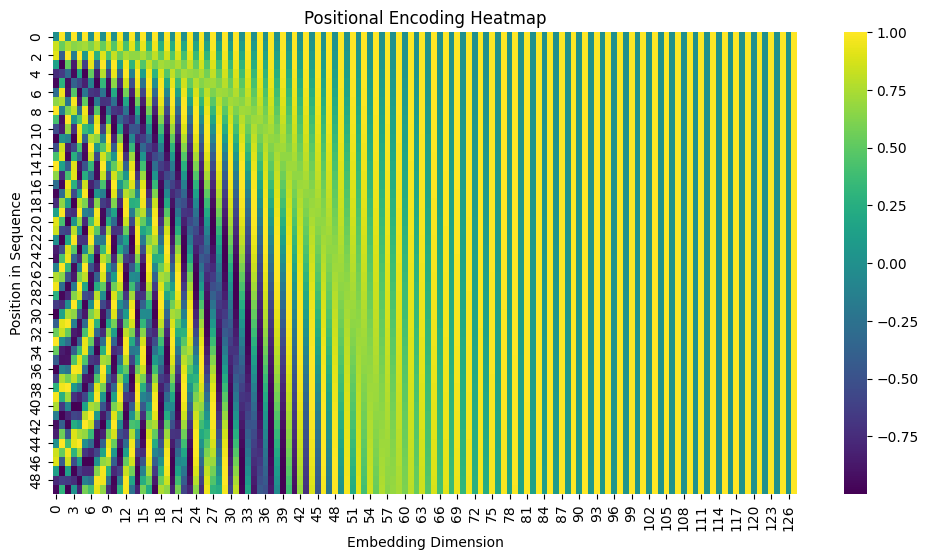

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define parameters (you can adjust these)
seq_len = 50
d_model = 128

# Get positional encoding
position_encoding = get_position_encoding(seq_len, d_model)

# Visualize the positional encoding
plt.figure(figsize=(12, 6))
sns.heatmap(position_encoding.numpy(), cmap="viridis")
plt.title("Positional Encoding Heatmap")
plt.xlabel("Embedding Dimension")
plt.ylabel("Position in Sequence")
plt.show()

# creating the add and normalisation layer

In [160]:
def add_norm(prev,input):
  result=prev+input;
  return torch.nn.functional.normalize(result);

# Creating the Encoder Sublayer

In [161]:
class EncoderSublayer(nn.Module):
  def __init__(self,d_model,num_heads,ffn_dim) -> None:
    super(EncoderSublayer,self).__init__()
    self.multihead=MultiHeadAttention(heads=num_heads,d_model=d_model)
    self.ffn=PositionWiseFFN(d_model=d_model,d_ff=ffn_dim)
    self.d_model=d_model
    self.ffn_dim=ffn_dim
  def forward(self,input_embeddings):
    add_norm_1=add_norm(prev=input_embeddings,input=self.multihead(input_embeddings))
    add_norm_2=add_norm(prev=add_norm_1,input=self.ffn(add_norm_1))
    return add_norm_2

## Adding the test case for the encoder sublayer

In [162]:
# Test case for EncoderSublayer

# Define input dimensions
batch_size = 2
sequence_length = 3
embedding_dim = 4
num_heads = 2
ffn_dim = 8 # Dimension of the feed-forward hidden layer

# Create sample input embeddings with shape (batch_size * sequence_length, embedding_dim)
sample_input_embeddings = torch.randn(batch_size * sequence_length, embedding_dim)

print("Sample Input Embeddings Shape for EncoderSublayer:", sample_input_embeddings.shape)

# Instantiate the EncoderSublayer module
encoder_sublayer = EncoderSublayer(d_model=embedding_dim, num_heads=num_heads, ffn_dim=ffn_dim)

# Pass the sample input embeddings through the EncoderSublayer module
try:
  output_encoder_sublayer = encoder_sublayer(sample_input_embeddings)
  print("EncoderSublayer Output Shape:", output_encoder_sublayer.shape)
except Exception as e:
  print(f"An error occurred during the EncoderSublayer test: {e}")

Sample Input Embeddings Shape for EncoderSublayer: torch.Size([6, 4])
EncoderSublayer Output Shape: torch.Size([6, 4])


# Generator will be used to get the final numerical values from the vectorized output

In [163]:
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    "Define standard linear + softmax generation step."

    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [164]:
# ---------------------------
# Test case for Generator
# ---------------------------

# Define input dimensions
batch_size = 1
sequence_length = 10
d_model = 4
vocab_size = 10

# Dummy input (like decoder hidden states for 10 tokens)
sample_generator_input = torch.randn(batch_size * sequence_length, d_model)
print("Sample Generator Input Shape:", sample_generator_input.shape)

# Instantiate generator
generator = Generator(d_model=d_model, vocab=vocab_size)

# Forward pass
output_generator = generator(sample_generator_input)
print("Generator Output Shape:", output_generator.shape)

# ---------------------------
# Get NEXT WORD prediction
# ---------------------------

# Take the last token’s logits (the 10th in the sequence)
last_token_logits = output_generator[-1]  # shape: (vocab_size,)
print(last_token_logits)
# Greedy decoding (argmax)
next_token_id = torch.argmax(last_token_logits)
print("Predicted Next Token ID:", next_token_id)

# Example vocab mapping (you can replace with your german_vocab)
# dummy_vocab = {i: f"token_{i}" for i in range(vocab_size)}
# print("Predicted Next Word:", dummy_vocab[next_token_id])

Sample Generator Input Shape: torch.Size([10, 4])
Generator Output Shape: torch.Size([10, 10])
tensor([-3.3804, -3.1859, -1.2145, -2.6592, -3.2353, -1.9069, -2.6890, -1.9590,
        -2.6726, -2.3876], grad_fn=<SelectBackward0>)
Predicted Next Token ID: tensor(2)


# Creating the Encoder

In [165]:
class Encoder(nn.Module):
  def __init__(self,d_model,num_heads,ffn_dim,num_layers,n=None) -> None:
    super(Encoder,self).__init__()
    self.num_heads=num_heads
    self.num_layers=num_layers
    self.d_model=d_model
    self.ffn_dim=ffn_dim
    self.n=n
    # Use nn.ModuleList to correctly register sublayer parameters
    self.encoder_layers=nn.ModuleList([EncoderSublayer(d_model=d_model,num_heads=num_heads,ffn_dim=ffn_dim) for i in range(0,num_layers)]);
  def forward(self,input_embedding): # input_embedding shape is (batch_size * sequence_length, d_model)
    pe=None
    if (self.n!=None):
     pe=get_position_encoding(input_embedding.size(0),self.d_model,self.n)
    else:
     pe=get_position_encoding(input_embedding.size(0),self.d_model)
    print("positional encoding",pe.shape)
    print("input embedding",input_embedding.shape)

    result=add_norm(prev=input_embedding,input=pe)
    for i in range(self.num_layers):
      result=self.encoder_layers[i](result)
    return result

## Adding the test case for the Encoder

In [166]:
# Test case for Encoder

# Define input dimensions
batch_size = 2
sequence_length = 10
d_model = 128 # Make sure d_model is divisible by num_heads
num_heads = 4
ffn_dim = 256 # Dimension of the feed-forward hidden layer
num_layers = 2 # Number of encoder layers

# Create sample input embeddings with shape (batch_size, sequence_length, d_model)
sample_input_embeddings = torch.randn(batch_size* sequence_length, d_model)

print("Sample Input Embeddings Shape for Encoder:", sample_input_embeddings.shape)

# Instantiate the Encoder module
encoder = Encoder(d_model=d_model, num_heads=num_heads, ffn_dim=ffn_dim, num_layers=num_layers)

# Pass the sample input embeddings through the Encoder module

output_encoder = encoder(sample_input_embeddings)
print("Encoder Output Shape:", output_encoder.shape)


Sample Input Embeddings Shape for Encoder: torch.Size([20, 128])
positional encoding torch.Size([20, 128])
input embedding torch.Size([20, 128])
Encoder Output Shape: torch.Size([20, 128])



# Decoder implmentation

# Decoder sublayer impmentation

In [167]:
class DecoderSublayer(nn.Module):
  def __init__(self,batch_size,sentence_len,dim_heads,d_model,ff_dim):
    super(DecoderSublayer,self).__init__();
    self.batch_size=batch_size;
    self.sentence_len=sentence_len;
    self.dim_heads=dim_heads;
    self.d_model=d_model;
    self.ff_dim=ff_dim;
    self.mask=create_look_ahead_mask(seq_len=sentence_len*batch_size);
    #first we create the masked multihead attention
    self.masked_head_attention=MultiHeadAttention(heads=dim_heads,d_model=d_model,dropout=0.1,mask=self.mask);
    #second we create the multihead attention
    self.multihead_attention=MultiHeadAttention(heads=dim_heads,d_model=d_model,dropout=0.1);
    self.ffn=PositionWiseFFN(d_model=d_model,d_ff=ff_dim);
  def forward(self,input_embeddings,encoder_output_embedding):
    result1=add_norm(prev=input_embeddings,input=self.masked_head_attention(input_embeddings,input_embeddings));
    result_of_cross_attention=self.multihead_attention(result1,encoder_output_embedding);
    result2=add_norm(prev=result1,input=result_of_cross_attention);
    result3=add_norm(prev=result2,input=self.ffn(result2));
    return result3;

In [168]:
# Test case for DecoderSublayer

# Define input dimensions
batch_size = 2
sequence_length = 10
d_model = 128 # Make sure d_model is divisible by num_heads
num_heads = 4
ffn_dim = 256 # Dimension of the feed-forward hidden layer

# Create sample input embeddings with shape (batch_size, sequence_length, d_model)
# Decoder input embeddings
sample_decoder_input_embeddings = torch.randn(batch_size * sequence_length, d_model)
# Encoder output embeddings (for cross-attention)
sample_encoder_output_embeddings = torch.randn(batch_size * sequence_length, d_model)


print("Sample Decoder Input Embeddings Shape for DecoderSublayer:", sample_decoder_input_embeddings.shape)
print("Sample Encoder Output Embeddings Shape for DecoderSublayer:", sample_encoder_output_embeddings.shape)


# Instantiate the DecoderSublayer module
decoder_sublayer = DecoderSublayer(batch_size=batch_size, sentence_len=sequence_length, dim_heads=num_heads, d_model=d_model, ff_dim=ffn_dim)

# Pass the sample input embeddings and encoder output through the DecoderSublayer module
try:
  output_decoder_sublayer = decoder_sublayer(sample_decoder_input_embeddings, sample_encoder_output_embeddings)
  print("DecoderSublayer Output Shape:", output_decoder_sublayer.shape)
except Exception as e:
  print(f"An error occurred during the DecoderSublayer test: {e}")

Sample Decoder Input Embeddings Shape for DecoderSublayer: torch.Size([20, 128])
Sample Encoder Output Embeddings Shape for DecoderSublayer: torch.Size([20, 128])
DecoderSublayer Output Shape: torch.Size([20, 128])


# Decoder Full Part

In [169]:
class Decoder(nn.Module):
   def __init__(self,batch_size,sentence_len,num_heads,d_model,ffn_dim,num_layers,n=None) -> None:
    super(Decoder,self).__init__()
    self.num_heads=num_heads
    self.num_layers=num_layers
    self.d_model=d_model
    self.ffn_dim=ffn_dim
    self.n=n
    # Use nn.ModuleList to correctly register sublayer parameters
    self.layers=nn.ModuleList([DecoderSublayer(batch_size=batch_size,sentence_len=sentence_len,dim_heads=num_heads,d_model=d_model,ff_dim=ffn_dim) for i in range(0,num_layers)]);

   def forward(self,input_embeddings,encoder_output_embeddings): # input_embeddings shape is (batch_size * sequence_length, d_model)
      pe=get_position_encoding(input_embeddings.size(0),self.d_model)
      print(pe.shape);
      print(input_embeddings.shape)
      result=add_norm(pe,input_embeddings)
      for layer in self.layers:
        result=add_norm(result,layer(result,encoder_output_embeddings))
      return result

In [170]:
# Test case for Decoder

# Define input dimensions
batch_size = 2
sequence_length = 10
d_model = 128 # Make sure d_model is divisible by num_heads
num_heads = 4
ffn_dim = 256 # Dimension of the feed-forward hidden layer
num_layers = 2 # Number of decoder layers

# Create sample input embeddings with shape (batch_size * sequence_length, d_model)
# Decoder input embeddings
sample_decoder_input_embeddings = torch.randn(batch_size * sequence_length, d_model)
# Encoder output embeddings (for cross-attention)
sample_encoder_output_embeddings = torch.randn(batch_size * sequence_length, d_model)

print("Sample Decoder Input Embeddings Shape for Decoder:", sample_decoder_input_embeddings.shape)
print("Sample Encoder Output Embeddings Shape for Decoder:", sample_encoder_output_embeddings.shape)

# Instantiate the Decoder module
decoder = Decoder(batch_size=batch_size, sentence_len=sequence_length, num_heads=num_heads, d_model=d_model, ffn_dim=ffn_dim, num_layers=num_layers)

# Pass the sample input embeddings and encoder output through the Decoder module

output_decoder = decoder(sample_decoder_input_embeddings, sample_encoder_output_embeddings)
print("Decoder Output Shape:", output_decoder.shape)


Sample Decoder Input Embeddings Shape for Decoder: torch.Size([20, 128])
Sample Encoder Output Embeddings Shape for Decoder: torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
Decoder Output Shape: torch.Size([20, 128])


# Transformer full implementation

In [171]:
class EncoderDecoder(nn.Module):
  def __init__(self,batch_size,sentence_len,num_heads,d_model,ffn_dim,num_layers,src_vocab_size,tgt_vocab_size,lang1_special_token={"[PAD]": 0,"[UNK]": 2,"[CLS]": 3,"[SEP]": 4,"[MASK]": 5 },lang2_special_token= {"[PAD]": 0,"[UNK]": 100,
    "[CLS]": 101,
    "[SEP]": 102,
    "[MASK]": 103  },n=None) -> None:
    super(EncoderDecoder,self).__init__()
    # Register Encoder and Decoder as submodules
    self.encoder = Encoder(d_model=d_model, num_heads=num_heads, ffn_dim=ffn_dim, num_layers=num_layers, n=n)
    self.decoder = Decoder(batch_size=batch_size, sentence_len=sentence_len, num_heads=num_heads, d_model=d_model, ffn_dim=ffn_dim, num_layers=num_layers, n=n)
    self.d_model = d_model
    self.sentence_len = sentence_len
    self.batch_size = batch_size
    self.lang1_special_token=lang1_special_token
    self.lang2_special_token=lang2_special_token

    #now creating the embedding layers
    self.target_embedding=EmbeddingLayer(vocab_size=tgt_vocab_size,d_model=d_model)
    self.source_embedding=EmbeddingLayer(vocab_size=src_vocab_size,d_model=d_model)
    # now creating the genrator for the decoder
    self.generator=Generator(d_model=d_model,vocab=tgt_vocab_size)

  def forward(self, source_input, source_padding_mask=None, target_padding_mask=None):
    # Create padding masks
    #
    seq_len=self.batch_size*self.sentence_len
    look_ahead_mask = torch.triu(torch.ones((seq_len, seq_len), dtype=torch.bool), diagonal=1)
    #
    #
    #
    #first refined the input of the encoder that is converting it from tokenized numerical value to vectorized form
    source_input= source_input.view(-1)
    source_input=self.source_embedding(source_input)

    #now we will fed this ouput to the encoder and get the ouptut and then use it for our further calculation
    encoder_output=self.encoder(source_input)

    #now for generating the output from the decoder is extracted by processing it sequence_length*batch_size times
    total_token_len=self.batch_size*self.sentence_len
    #we will start with the start token
    sen=[self.lang2_special_token["[CLS]"]]
    while( len(sen)<total_token_len and sen[-1]!=self.lang2_special_token["[SEP]"]):
     target_input=sen+[self.lang2_special_token["[PAD]"] for i in range(len(sen),total_token_len)]

     target_input_reshaped=self.target_embedding(torch.tensor(target_input))
     decoder_output = self.decoder(target_input_reshaped, encoder_output)
     output=self.generator(decoder_output)
     sen.append(torch.argmax(output[-1]).item())

    return torch.tensor(sen)

In [172]:
# Test case for EncoderDecoder

# Define input dimensions
batch_size = 2
sequence_length = 10
d_model = 128 # Make sure d_model is divisible by num_heads
num_heads = 4
ffn_dim = 256 # Dimension of the feed-forward hidden layer
num_layers = 2 # Number of encoder and decoder layers
src_vocab_size = 1000 # Source vocabulary size
tgt_vocab_size = 2000 # Target vocabulary size

# Create sample input tensors
# Source input (e.g., encoder input) - Dummy token IDs
sample_source_input = torch.randint(0, src_vocab_size, (batch_size, sequence_length))


print("Sample Source Input Shape:", sample_source_input.shape)

# Instantiate the EncoderDecoder module
transformer = EncoderDecoder(batch_size=batch_size, sentence_len=sequence_length, num_heads=num_heads, d_model=d_model, ffn_dim=ffn_dim, num_layers=num_layers, src_vocab_size=src_vocab_size, tgt_vocab_size=tgt_vocab_size)

# Pass the sample inputs through the Transformer

output_transformer = transformer(sample_source_input)
print("Transformer Output Shape:", output_transformer.shape)

Sample Source Input Shape: torch.Size([2, 10])
positional encoding torch.Size([20, 128])
input embedding torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
Transformer Output Shape: torch.Size(

In [173]:
total_params = sum(p.numel() for p in transformer.parameters() if p.requires_grad)
print(total_params)

1301968


# Checking the Parameters count of the model

In [174]:
import torch.nn as nn

class SimpleModuleWithParameters(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleModuleWithParameters, self).__init__()
        self.linear_layer = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear_layer(x)

# Create an instance of the class
input_dim = 10
output_dim = 5
simple_model = SimpleModuleWithParameters(input_dim, output_dim)

# Access and print the parameters
print("Parameters of the SimpleModuleWithParameters:")
for name, parameter in simple_model.named_parameters():
    if parameter.requires_grad:
        print(f"Parameter Name: {name}, Shape: {parameter.shape}, Dimensions: {parameter.dim()}")

# Get the total number of trainable parameters
total_params_simple = sum(p.numel() for p in simple_model.parameters() if p.requires_grad)
print(f"\nTotal trainable parameters in SimpleModuleWithParameters: {total_params_simple}")

Parameters of the SimpleModuleWithParameters:
Parameter Name: linear_layer.weight, Shape: torch.Size([5, 10]), Dimensions: 2
Parameter Name: linear_layer.bias, Shape: torch.Size([5]), Dimensions: 1

Total trainable parameters in SimpleModuleWithParameters: 55


In [175]:
class ParentModule(nn.Module):
  def __init__(self) -> None:
     super(ParentModule,self).__init__()
     self.simple_model=SimpleModuleWithParameters(10,5)
  def forward(self,x):
    return self.simple_model(x)
module_parent=ParentModule()

total_params_simple = sum(p.numel() for p in module_parent.parameters() )
print(f"\nTotal trainable parameters in SimpleModuleWithParameters: {total_params_simple}")


Total trainable parameters in SimpleModuleWithParameters: 55


In [176]:
# Display parameter counts for existing module instances

print(f"Total trainable parameters in MultiHeadAttention instance: {sum(p.numel() for p in multi_head_attention.parameters() if p.requires_grad)}")
print(f"Total trainable parameters in Encoder instance: {sum(p.numel() for p in encoder.parameters() if p.requires_grad)}")
print(f"Total trainable parameters in Decoder instance: {sum(p.numel() for p in decoder.parameters() if p.requires_grad)}")
print(f"Total trainable parameters in EncoderDecoder instance: {sum(p.numel() for p in transformer.parameters() if p.requires_grad)}")

# Print the number of trainable parameters in each EncoderSublayer
print("\nTrainable parameters in each EncoderSublayer:")
if hasattr(encoder, 'encoder_layers'):
    for i, layer in enumerate(encoder.encoder_layers):
        total_params_sublayer = sum(p.numel() for p in layer.parameters() if p.requires_grad)
        print(f"  EncoderSublayer {i+1}: {total_params_sublayer}")

# Print the number of trainable parameters in each DecoderSublayer
print("\nTrainable parameters in each DecoderSublayer:")
if hasattr(decoder, 'layers'):
    for i, layer in enumerate(decoder.layers):
        total_params_sublayer = sum(p.numel() for p in layer.parameters() if p.requires_grad)
        print(f"  DecoderSublayer {i+1}: {total_params_sublayer}")

Total trainable parameters in MultiHeadAttention instance: 66048
Total trainable parameters in Encoder instance: 263936
Total trainable parameters in Decoder instance: 396032
Total trainable parameters in EncoderDecoder instance: 1301968

Trainable parameters in each EncoderSublayer:
  EncoderSublayer 1: 131968
  EncoderSublayer 2: 131968

Trainable parameters in each DecoderSublayer:
  DecoderSublayer 1: 198016
  DecoderSublayer 2: 198016


In [177]:
# Count parameters by dimension in the Transformer model
count_dim_1 = 0
count_dim_2 = 0
for name, parameter in transformer.named_parameters():
        if parameter.dim() == 1:
            count_dim_1 += 1
        elif parameter.dim() == 2:
            count_dim_2 += 1

print("Parameter counts by dimension in the Transformer model:")
print(f"  Parameters with dimension 1: {count_dim_1}")
print(f"  Parameters with dimension 2: {count_dim_2}")

Parameter counts by dimension in the Transformer model:
  Parameters with dimension 1: 33
  Parameters with dimension 2: 35


In [178]:
import torch
import torch.nn as nn

# Define source and target vocabulary sizes and embedding dimension
src_vocab_size = 1000
tgt_vocab_size = 2000
d_model = 128

# Create embedding layers
src_embedding_layer = nn.Embedding(src_vocab_size, d_model)
tgt_embedding_layer = nn.Embedding(tgt_vocab_size, d_model)

# Example usage with dummy input tensors (token IDs)
batch_size = 2
sequence_length = 10

sample_source_input_tokens = torch.randint(0, src_vocab_size, (batch_size, sequence_length))
sample_target_input_tokens = torch.randint(0, tgt_vocab_size, (batch_size, sequence_length))

# Embed the input tokens
source_embedded = src_embedding_layer(sample_source_input_tokens)
target_embedded = tgt_embedding_layer(sample_target_input_tokens)

print("Source Embedded Shape:", source_embedded.shape)
print("Target Embedded Shape:", target_embedded.shape)

Source Embedded Shape: torch.Size([2, 10, 128])
Target Embedded Shape: torch.Size([2, 10, 128])


In [179]:
import json

with open("sentence_pairs.json", "r", encoding="utf-8") as f:
    loaded_sentence_pairs = json.load(f)

print("Data loaded from sentence_pairs.json:")
print(loaded_sentence_pairs)

Data loaded from sentence_pairs.json:
[{'german': 'Deine Habgier wird noch dein Tod sein.', 'english': "It's greed that it's gonna be the death of you, 'cause you..."}, {'german': '- Vega.', 'english': 'Vega.'}, {'german': 'Sagen Sie einfach stopp.', 'english': 'Just say when.'}, {'german': '- Warte.', 'english': '- Wait.'}]


#We will now use the bert-cased-model for the tokenisation

# Tokenizer model for the english

In [180]:
from transformers import BertTokenizer

# Load the bert-large-cased tokenizer
english_tokenizer = BertTokenizer.from_pretrained("bert-large-cased")
print("bert-large-cased tokenizer loaded.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

bert-large-cased tokenizer loaded.


In [181]:
english_tokenizer.encode("hello how are you")

[101, 19082, 1293, 1132, 1128, 102]

# tokenizer for the german

In [183]:
from transformers import BertTokenizer

german_tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/485k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

In [184]:
german_tokenizer.encode("Hallo! Wie geht es Ihnen?")

[3, 5850, 26910, 26982, 1316, 1398, 229, 9830, 26972, 4]

tensor([101, 174])

In [188]:
print("English tokenizer vocab size:", english_tokenizer.vocab_size)
print("German tokenizer vocab size:", german_tokenizer.vocab_size)

English tokenizer vocab size: 28996
German tokenizer vocab size: 30000


In [189]:
# Test case for EncoderDecoder with a real English sentence

# Define input dimensions
batch_size = 1 # Testing with a single sentence
sequence_length = 20 # Choose a suitable sequence length for padding/truncation
d_model = 128 # Make sure d_model is divisible by num_heads
num_heads = 4
ffn_dim = 256 # Dimension of the feed-forward hidden layer
num_layers = 2 # Number of encoder and decoder layers
src_vocab_size = english_tokenizer.vocab_size # Use actual English vocab size
tgt_vocab_size = german_tokenizer.vocab_size # Use actual German vocab size

# Real English sentence
english_sentence = "It's greed that it's gonna be the death of you, 'cause you..."

# Tokenize the English sentence
tokenized_english_sentence = english_tokenizer(english_sentence, return_tensors="pt", padding="max_length", truncation=True, max_length=sequence_length)
sample_source_input = tokenized_english_sentence["input_ids"]

print("Sample Source Input Shape:", sample_source_input.shape)
print("Sample Source Input (Token IDs):", sample_source_input)

# Instantiate the EncoderDecoder module with actual vocab sizes
# Ensure the batch_size and sentence_len match the tokenized input shape
transformer = EncoderDecoder(batch_size=batch_size, sentence_len=sequence_length, num_heads=num_heads, d_model=d_model, ffn_dim=ffn_dim, num_layers=num_layers, src_vocab_size=src_vocab_size, tgt_vocab_size=tgt_vocab_size)

# Pass the sample inputs through the Transformer
# The forward method expects input of shape (batch_size, sequence_length)
output_transformer = transformer(sample_source_input)
print("Transformer Output Shape:", output_transformer.shape)
print("Transformer Output (Token IDs):", output_transformer)

# Decode the output token IDs back to text (using German tokenizer for demonstration)
# Assuming the output_transformer is a tensor of shape (batch_size, generated_sequence_length)
decoded_output = german_tokenizer.decode(output_transformer.squeeze().tolist(), skip_special_tokens=True)
print("Decoded Transformer Output:", decoded_output)

Sample Source Input Shape: torch.Size([1, 20])
Sample Source Input (Token IDs): tensor([[  101,  1135,   112,   188,   176, 15825,  1115,  1122,   112,   188,
          6100,  1129,  1103,  1473,  1104,  1128,   117,   112,  2612,   102]])
positional encoding torch.Size([20, 128])
input embedding torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128])
torch.Size([20, 128]